### library import

In [2]:
import numpy as np
import scipy.misc as scm
from scipy.stats import poisson
import scipy.integrate as integrate
import math
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Modelingクラス

In [41]:
class Modeling:
    
    # 1,準備
    # Poisson過程
    # 単位時間あたりの到着数 λ
    # 時刻tまでにn人が到着する確率
    def poisson_probability(self, n, t, lambda_poisson):
        return math.e**(-lambda_poisson * t) * (lambda_poisson * t)**n / math.factorial(n)

    # Poisson過程
    # 累積確率
    def cumulative_poisson_probability(self, n, t, lambda_poisson):
        cumulative_probability = 0
        for i in range(0, n + 1):
            cumulative_probability += math.e**(-lambda_poisson * t) * (lambda_poisson * t)**i / math.factorial(i)
        return cumulative_probability

    # Gamma分布
    # 時刻tにn人目が到着する確率
    def gamma_probability(self, n, t, lambda_poisson):
        return lambda_poisson**n * t**(n - 1) * math.e**(-lambda_poisson * t) / math.factorial(n - 1)

    # Gamma分布
    # 累積確率
    def cumulative_gamma_probability(self, n, T, lambda_poisson):
        cumulative_probability, abserr = integrate.quad(lambda t: self.gamma_probability(n, t, lambda_poisson), 0, T)
        return cumulative_probability

    # 時刻Tまでにn人現われるときに，時刻t(≤ T)にn人目が到着する(時刻tからTの間には一人も現われない)確率g(n,t,T)
    def g(self, n, t, T, lambda_poisson):
        return lambda_poisson**n * t**(n - 1) * math.e**(-lambda_poisson * T) / math.factorial(n - 1)

    # 多数決による判定精度
    # n人で多数決を行う場合の判定精度をacc(n)で表す
    # 個人の判定精度をpとする
    def acc_odd(self, n, p): # nが奇数2i-1のとき
        i = int((n + 1) / 2)
        acc = 0
        for j in range(i):
            acc += scm.comb(2 * i - 1, j) * p**(2 * i - 1 - j) * (1 - p)**j
        return acc

    def acc_even(self, n, p): # nが偶数2iのとき
        i = int(n / 2)
        acc = 0
        for j in range(i):
            acc += scm.comb(2 * i, j) * p**(2 * i - j) * (1 - p)**j
        acc += scm.comb(2 * i, i) * p**i * (1 - p)**i / 2
        return acc

    def acc(self, n, p):
        if n % 2 == 1:
            return self.acc_odd(n, p)
        else:
            return self.acc_even(n, p)

    # 2,単純な意見集約法

    # 2.1,時刻優先意見集約法
    # 時刻tまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def time_priority_method(self, t, w, p, lambda_poisson):
        if t == 0: return 0
        utility = 0
        for i in range(1, 2 * lambda_poisson * t, 1):
                utility += self.poisson_probability(i, t, lambda_poisson) * self.acc(i, p)
        utility -= w * t
        return utility

    # 増減を調べる
    def inc_and_dec_time_priority_method(self, w, p, lambda_poisson):
        for t in range(1, 1000):
            diff = self.time_priority_method(t + 1, w, p, lambda_poisson) - self.time_priority_method(t, w, p, lambda_poisson)
            if diff < 0: return t

    # 2.2, 投票数優先意見集約法
    # n人集まるまで待って多数決を行う
    # 効用を予測精度と所要時間の差で表す
    def poll_priority_method(self, n, w, p, lambda_poisson):
        if n == 0: return 0
        utility = 0
        utility += self.acc(n, p)
        # 積分を行う
        value, abserr = integrate.quad(lambda t: w * t * self.gamma_probability(n, t, lambda_poisson), 0, 1000)
        utility -= value
        return utility

    # 増減を調べる
    def inc_and_dec_poll_priority_method(self, w, p, lambda_poisson):
        for n in range(1, 1000):
            diff = self.poll_priority_method(2 * n + 1, w, p, lambda_poisson) - self.poll_priority_method(2 * n - 1, w, p, lambda_poisson)
            if diff < 0: return n

    # 2.3, 得票数優先意見集約法
    # 先にk票集まった案に決定する
    # 効用を予測精度と所要時間の差で表す
    def vote_priority_method(self, k, w, p, lambda_poisson):
        if k == 0: return 0
        utility = 0
        for j in range(k, 2 * k):
            temp_probability = scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p
            # 積分を行う
            value, abserr = integrate.quad(lambda t: w * t * self.gamma_probability(j, t, lambda_poisson), 0, 1000)
            utility += temp_probability * (1 - value)
        return utility

    # 増減を調べる
    def inc_and_dec_vote_priority_method(self, w, p, lambda_poisson):
        for k in range(1, 1000):
            diff = self.vote_priority_method(k + 1, w, p, lambda_poisson) - self.vote_priority_method(k, w, p, lambda_poisson)
            if diff < 0: return k

    # 3, 組み合わせ意見集約法
    # 方法1, 時刻T1まで待つ
    # 方法2, 投票者数がnに達すれば判定し終了、達しなければT1まで待つ
    # 方法3, 時刻T2(=< T1)までに投票者数がnに達すれば判定し終了、達しなければT1まで待つ(T2 = T1とすれば方法2と方法3は同じ)
    # 方法4, 得票者数がkに達すれば判定し終了、達しなければT1まで待つ
    # 方法5, 時間T2(=< T1)までに得票者数がkに達すれば判定を終了し、達しなければT1まで待つ (T2 = T1とすれば方法4と方法5は同じ)

    # 方法1(時刻優先意見集約法と同じ) 時刻T1まで待つ
    def method1(self, t, w, p, lambda_poisson):
        return self.time_priority_method(t, w, p, lambda_poisson)

    # 増減を調べる
    def inc_and_dec_method1(self, w, p, lambda_poisson):
        return self.inc_and_dec_time_priority_method(w, p, lambda_poisson)

    # 方法2 投票者数がnに達すれば判定し終了、達しなければT1まで待つ
    def method2(self, T1, n, w, p, lambda_poisson):
        if n == 0: return 0
        utility = 0
        for i in range(0, n):
            utility += self.poisson_probability(i, T1, lambda_poisson) * (self.acc(i, p) - w * T1)
        # 積分を行う
        value, abserr = integrate.quad(lambda t: (self.acc(n, p) - w * t) * self.gamma_probability(n, t, lambda_poisson), 0, T1)
        utility += value
        return utility

    # 増減を調べる
    def inc_and_dec_method2(self, T1, w, p, lambda_poisson):
        for n in range(1, 50):
            diff = self.method2(T1, 2 * n + 1, w, p, lambda_poisson) - self.method2(T1, 2 * n - 1, w, p, lambda_poisson)
            if diff < 0:
                return 2 * n - 1

    # 方法3 時刻T2(=< T1)までに投票者数がnに達すれば判定し終了、達しなければT1まで待つ(T2 = T1とすれば方法2と方法3は同じ)
    def method3(self, T1, T2, n, w, p, lambda_poisson):
        if n == 0: return 0
        utility = 0
        # T1までにn人集まらないとき
        for i in range(0, n):
            utility += self.poisson_probability(i, T1, lambda_poisson) * (self.acc(i, p) - w * T1)
        # T1までにn人集まるがT2までにはn人集まらないとき
        for i in range(n, 100):
            utility += (self.poisson_probability(i, T1, lambda_poisson) - self.poisson_probability(i, T2, lambda_poisson)) * (self.acc(i, p) - w * T1)
        # 積分を行う
        # T2までにn人集まるとき
        value, abserr = integrate.quad(lambda t: (self.acc(n, p) - w * t) * self.gamma_probability(n, t, lambda_poisson), 0, T2)
        utility += value
        return utility


    # 増減を調べる
    def inc_and_dec_method3(self, T1, T2, w, p, lambda_poisson):
        for n in range(1, 50):
            diff = self.method3(T1, T2, 2 * n + 1, w, p, lambda_poisson) - self.method3(T1, T2, 2 * n - 1, w, p, lambda_poisson)
            if diff < 0:
                return 2 * n - 1
            
    # 方法4 得票者数がkに達すれば判定し終了、達しなければT1まで待つ
    def method4(self, T1, k, w, p, lambda_poisson):
        if k == 0: return 0
        utility = 0
        for i in range(0, k):
            for j in range(i, 2 * i):
                utility += self.poisson_probability(j, T1, lambda_poisson) * (scm.comb(j - 1, j - i) * p**(i - 1) * (1 - p)**(j - i) * p) * (1 - w * T1)
        # ----被積分関数を定義----
        def integrand_for_method4(t):
            integrand = 0
            for j in range(k, 2 * k):
                integrand += (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p) * (1 - w * t) * self.gamma_probability(j, t, lambda_poisson)
            return integrand
        # --------終わり--------
        #積分を行う
        value, abserr = integrate.quad(integrand_for_method4, 0, T1)
        utility += value
        return utility

    # 方法5 時間T2(=< T1)までに得票者数がkに達すれば判定を終了し、達しなければT1まで待つ (T2 = T1とすれば方法4と方法5は同じ)
    def method5(self, T1, T2, k, w, p, lambda_poisson):
        if k == 0: return 0
        utility = 0
        # T1までにk票集まらないとき
        for i in range(0, k):
            for j in range(i, 2 * i):
                utility += self.poisson_probability(j, T1, lambda_poisson) * (scm.comb(j - 1, j - i) * p**(i - 1) * (1 - p)**(j - i) * p) * (1 - w * T1)
        # T1までにk票集まるがT2までにはk票集まらないとき
        for i in range(k, 100):
            for j in range(i, 2 * i):
                utility += (self.poisson_probability(i, T1, lambda_poisson) - self.poisson_probability(i, T2, lambda_poisson)) * (scm.comb(j - 1, j - i) * p**(i - 1) * (1 - p)**(j - i) * p) * (1 - w * T1)
        # 積分を行う
        # T2までにk票集まるとき
        # ----被積分関数を定義----
        def integrand_for_method5(t):
            integrand = 0
            for j in range(k, 2 * k):
                integrand += (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p) * (1 - w * t) * self.gamma_probability(j, t, lambda_poisson)
            return integrand
        # --------終わり--------
        value, abserr = integrate.quad(integrand_for_method5, 0, T2)
        utility += value
        return utility



### PlotGraphクラス

In [42]:
class PlotGraph:

    def __init__(self):
        sns.set_style("whitegrid")
        self.model = Modeling()

    def plot_poisson(self, time, lambda_poisson):
        x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(m.poisson_probability(x, time, lambda_poisson))
        plt.title('poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
        plt.xlabel('people')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_cumulative_poisson(self, time, lambda_poisson):
        x_axis = np.linspace(0, 2 * time * lambda_poisson, 2 * time * lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(m.cumulative_poisson_probability(int(x), time, lambda_poisson))
        plt.title('cumulative poisson time: {0} lambda: {1}'.format(time, lambda_poisson))
        plt.xlabel('people')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_gamma(self, people, lambda_poisson):
        x_axis = np.linspace(0, 2 * people / lambda_poisson , 2 * people / lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(m.gamma_probability(people, x, lambda_poisson))
        plt.title('gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
        plt.xlabel('time')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_cumulative_gamma(self, people, lambda_poisson):
        x_axis = np.linspace(0, 2 * people / lambda_poisson , 2 * people / lambda_poisson + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(m.cumulative_gamma_probability(people, x, lambda_poisson))
        plt.title('cumulative gamma people: {0} lambda: {1}'.format(people, lambda_poisson))
        plt.xlabel('time')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_g(self, T, n, lambda_poisson):
        x_axis = np.linspace(0, T, T + 1)
        y_axis = []
        for x in x_axis:
            y_axis.append(m.g(n, x, T, lambda_poisson))
        plt.title("g T: {0} n: {1} lambda: {2}".format(T, n, lambda_poisson))
        plt.xlabel('time')
        plt.ylabel('probability')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_time_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('time priority method weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('time')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_poll_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.poll_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('poll priority method weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_vote_priority(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.vote_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('vote priority method weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('require vote people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method1(self, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.time_priority_method(int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method1 weight: {0} person_probability: {1}'.format(w, p))
        plt.xlabel('time')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method2(self, T1, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.method2(T1,int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method2 T1: {0} weight: {1} person_probability: {2}'.format(T1, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method3(self, T1, T2, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.method3(T1, T2, int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method3 T1: {0} T2: {1} weight: {2} person_probability: {3}'.format(T1, T2, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method4(self, T1, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.method4(T1,int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method4 T1: {0} weight: {1} person_probability: {2}'.format(T1, w, p))
        plt.xlabel('require vote people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

    def plot_method5(self, T1, T2, w, p, lambda_poisson):
        x_axis = np.linspace(0, 50, 51)
        y_axis = [m.method5(T1, T2, int(x), w, p, lambda_poisson) for x in x_axis]
        plt.title('method5 T1: {0} T2: {1} weight: {2} person_probability: {3}'.format(T1, T2, w, p))
        plt.xlabel('poll people')
        plt.ylabel('utility')
        plt.plot(x_axis, y_axis)
        plt.show()

### main

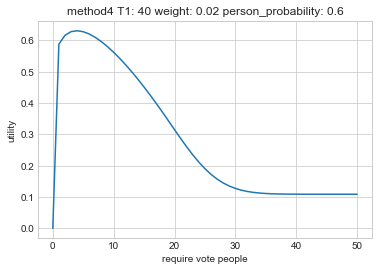

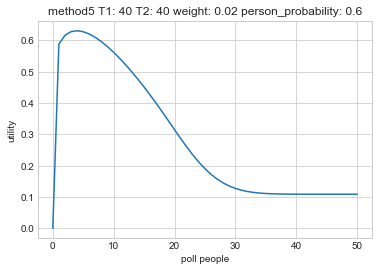

In [44]:
sns.set_style("whitegrid")
m = Modeling()
pg = PlotGraph()

# print m.inc_and_dec_time_priority_method(0.02, 0.6, 1)
# print m.inc_and_dec_poll_priority_method(0.02, 0.6, 1)
# print m.inc_and_dec_vote_priority_method(0.02, 0.6, 1)
# print m.inc_and_dec_method1(0.02, 0.6, 1)
# print m.inc_and_dec_method2(30, 0.02, 0.6, 1)
# print m.inc_and_dec_method3(30, 15, 0.02, 0.6, 1)

# pg.plot_poisson(30,1)
# pg.plot_cumulative_poisson(5,5)
# pg.plot_gamma(100,5)
# pg.plot_cumulative_gamma(100, 1)
# pg.plot_g(40, 20, 2)

# pg.plot_time_priority(0.02, 0.6, 1)
# pg.plot_poll_priority(0.02, 0.6, 1)
# pg.plot_vote_priority(0.02, 0.6, 1)
# pg.plot_method1(0.02, 0.6, 1)
# pg.plot_method2(30, 0.02, 0.6, 1)
# pg.plot_method3(30, 5, 0.02, 0.6, 1)
pg.plot_method4(40, 0.02, 0.6, 1)
pg.plot_method5(40, 40, 0.02, 0.6, 1)


In [6]:
# sns.set_style("whitegrid")
# pg = PlotGraph(50, 2)
# pg.plot_error_possibility_graph(5)
# pg.plot_error_possibility_graph_by_people_num()
# pg.plot_utility_possibility_average_graph(11, 13, 17, 0.5)
# pg.plot_utility_possibility_variance_graph(11, 13, 17, 0.5)
# pg.plot_utility_weight_average_graph(0.7, 11, 13, 17)
# pg.plot_utility_weight_variance_graph(0.7, 11, 13, 17)
# pg.plot_utility_possibility_average_graph_for_single_method(0.5)
# pg.plot_utility_possibility_variance_graph_for_single_method(0.5)
# pg.plot_utility_weight_average_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution(50, 50, 11, 13, 17)
# pg.plot_utility_weight_average_graph_with_uniform_distribution_for_single_method(50, 50)
# pg.plot_utility_weight_variance_graph_with_uniform_distribution_for_single_method(50, 50)

### テスト

In [33]:
m = Modeling()

# integrate g and poisson should be same
# def temp_f(t):
#     return m.g(10,t,5,2)
# value, abserr = integrate.quad(temp_f, 0, 5)
# print value
# print m.poisson_probability(10,5,2)
# print "--------------------------------------------------"

# # p_sum plus g_value should be 1.0
# p_sum = 0
# for i in range(0, 50):
#     p_sum += m.poisson_probability(i, 20, 3)
# print p_sum
# def test_g(t):
#     return m.trial_g(50, t, 20, 3)
# g_value, abserr = integrate.quad(test_g, 0, 20)
# print g_value
# print "--------------------------------------------------"

# # method2 p_sum should be 1.0
# def method2_p_sum(T1, n, w, lambda_poisson):
#     p_sum = 0
#     for i in range(0, n):
#         p_sum += m.poisson_probability(i, T1, lambda_poisson)
#     # 積分を行う
#     value, abserr = integrate.quad(lambda t: m.gamma_probability(n, t, lambda_poisson), 0, T1)
#     p_sum += value
#     return p_sum
# print method2_p_sum(20, 10, 0.02, 1)
# print "--------------------------------------------------"

# method3 p_sum should be 1.0
def method3_p_sum(T1, T2, n, w, lambda_poisson):
    p_sum = 0
    for i in range(0, n):
        p_sum += m.poisson_probability(i, T1, lambda_poisson)
    # 積分を行う
    value_1, abserr = integrate.quad(lambda t: m.gamma_probability(n, t, lambda_poisson), 0, T2)
    p_sum += value_1
    for i in range(n, 100):
        p_sum += m.poisson_probability(i, T1, lambda_poisson) - m.poisson_probability(i, T2, lambda_poisson)
    return p_sum
print method3_p_sum(30, 14, 10, 0.02, 1)
print "--------------------------------------------------"

# vote priority method acc (頭がこんがらがったので確かめ)
# def vote_priority_method(k, p):
#     if k == 0: return 0
#     acc = 0
#     for j in range(k, 2 * k):
#         acc += scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p
#     return acc
# print vote_priority_method(1, 0.9)
# print "--------------------------------------------------"

# method4 p_sum should be 1.
def method4_p_sum(T1, k, p, lambda_poisson):
    if k == 0: return 0
    p_sum = 0
    for i in range(0, k):
        for j in range(i, 2 * i):
            p_sum += m.poisson_probability(j, T1, lambda_poisson) * (scm.comb(j - 1, j - i) * p**(i - 1) * (1 - p)**(j - i) * p)
    # ----被積分関数を定義----
    def integrand_for_method4(t):
        integrand = 0
        for j in range(k, 2 * k):
            integrand += m.gamma_probability(j, t, lambda_poisson) * (scm.comb(j - 1, j - k) * p**(k - 1) * (1 - p)**(j - k) * p)
        return integrand
    # --------終わり--------
    #積分を行う
    value, abserr = integrate.quad(integrand_for_method4, 0, T1)
    p_sum += value
    return p_sum
print method4_p_sum(20, 30, 0.9, 1)

1.0
--------------------------------------------------
0.900321862442
